In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import tree
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import warnings

from pyit2fls import IT2FLS, Mamdani, IT2FS_Gaussian_UncertStd, IT2FS_plot, \
                     min_t_norm, max_s_norm, TR_plot, crisp, product_t_norm, bounded_sum_s_norm
from pyit2fls import IT2FS, trapezoid_mf, tri_mf

from numpy import linspace
from time import time
warnings.filterwarnings('ignore')

In [3]:
file_name = "Detection of COVID-19 Infection from Routine Blood Exams_dataset.xlsx"
df = pd.read_excel(file_name, sheet_name="Foglio1", nrows=279, usecols="A:P")

means = [61.336917562724, 8.55306859205776, 226.532129963899, 6.20047846889952, 1.18653846153846, 0.605741626794258,
         0.0550239234449761, 0.0144230769230769, 90.889010989011, 54.202166064982, 44.9172932330827, 89.8931297709924, 
         82.4779411764706, 380.448453608247]
# for determine means as nan data
for column, mean in zip(df.columns[1:-1], means):
    df[column].fillna(value=mean, inplace = True)

df['SESSO'].replace(['M','F'], [0,1],inplace=True)
df['TARGET'].replace([1, 2], [1,1], inplace=True)
# pure_df = df.dropna()
pure_df = df
pure_df

,SESSO,AGE,WBC,Piastrine,Neutrofili,Linfociti,Monociti,Eosinofili,Basofili,PCR,AST,ALT,ALP,GGT,LDH,TARGET
0,0,56,2.9,128.0,1.900000,0.800000,0.200000,0.000000,0.000000,29.000000,36.000000,18.000000,43.00000,21.000000,257.000000,1
1,0,56,3.5,151.0,2.100000,0.900000,0.400000,0.000000,0.000000,16.500000,25.000000,14.000000,50.00000,17.000000,207.000000,1
2,0,72,4.6,206.0,6.200478,1.186538,0.605742,0.055024,0.014423,193.700000,31.000000,22.000000,89.89313,82.477941,380.448454,1
3,0,72,16.5,316.0,14.000000,1.200000,0.300000,0.000000,0.000000,318.700000,96.000000,33.000000,80.00000,42.000000,651.000000,1
4,0,77,4.9,198.0,6.200478,1.186538,0.605742,0.055024,0.014423,90.889011,54.202166,44.917293,89.89313,82.477941,380.448454,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,1,40,5.6,270.0,6.200478,1.186538,0.605742,0.055024,0.014423,16.700000,22.000000,29.000000,78.00000,20.000000,380.448454,0
275,0,26,4.7,44.0,6.200478,1.186538,0.605742,0.055024,0.014423,47.500000,30.000000,44.000000,110.00000,93.000000,175.000000,0
276,1,44,15.7,356.0,6.200478,1.186538,0.605742,0.055024,0.014423,2.400000,31.000000,17.000000,89.89313,82.477941,272.000000,0
277,1,41,12.0,321.0,6.700000,2.300000,1.600000,1.300000,0.100000,41.200000,16.000000,11.000000,201.00000,14.000000,266.000000,0


In [4]:
dataset = pure_df.to_numpy()
np.random.seed(54)
train_index = np.random.rand(279) <= 0.7
test_index = np.logical_not(train_index)
train_dataset, test_dataset = dataset[train_index], dataset[test_index]

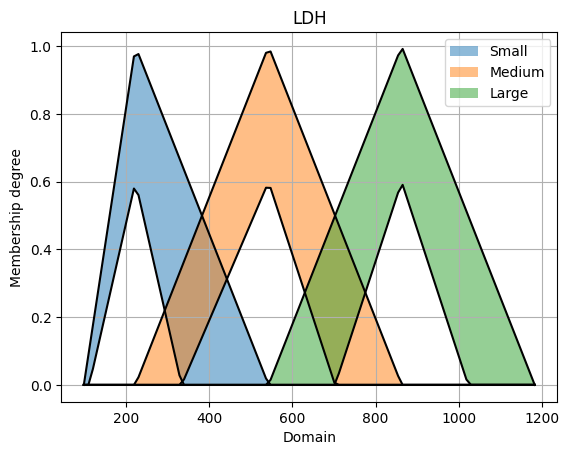

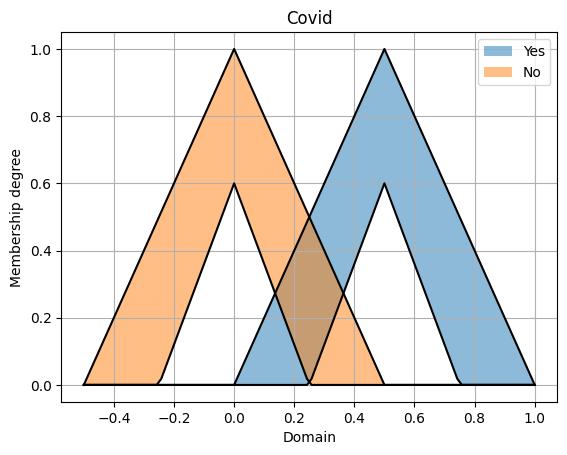

In [5]:
feature_names = ["SESSO", "AGE", "WBC", "Piastrine", "Neutrofili", "Linfociti", "Monociti", "Eosinofili", "Basofili", "PCR", "AST", "ALT", "ALP", "GGT", "LDH"]
all_features = train_dataset[:,0:-1]

all_feature_fuzzy_variables = []

for feature_index in range(15):
    feature_col = all_features[:, feature_index]
    feature_dict = {"name": feature_names[feature_index]}
    feature_min = np.min(feature_col)
    feature_max = np.max(feature_col)
    domain = linspace(feature_min, feature_max, 100)
    # bounds = boundries[feature_index]
    median =  (feature_max - feature_min) / 2
    Small = IT2FS(domain, 
              trapezoid_mf, [feature_min, (median-feature_min)/2,(median-feature_min)/2, median, 1],  # Trapezoidal UMF with 
                                                    # left = 0.,
                                                    # center left = 0.4,
                                                    # center right = 0.6, 
                                                    # right = 1., 
                                                    # and height = 1.
              tri_mf, [(median-feature_min)/4, (median-feature_min)/2, (median-feature_min)*(3/4), 0.6])       # Triangular LMF with 
                                                    # left = 0.25,
                                                    # center = 0.5,
                                                    # right = 0.75,
                                                    # and height = 0.6.
    Medium = IT2FS(domain, 
              trapezoid_mf, [(median-feature_min)/2, median, median, median + (feature_max - median)/2, 1.],  # Trapezoidal UMF with 
                                                    # left = 0.,
                                                    # center left = 0.4,
                                                    # center right = 0.6, 
                                                    # right = 1., 
                                                    # and height = 1.
              tri_mf, [(median-feature_min)*(3/4), median, median + (feature_max - median)/4, 0.6])       # Triangular LMF with 
                                                    # left = 0.25,
                                                    # center = 0.5,
                                                    # right = 0.75,
                                                    # and height = 0.6.
    Large = IT2FS(domain, 
              trapezoid_mf, [median,  median + (feature_max - median)/2,  median + (feature_max - median)/2, feature_max, 1.],  # Trapezoidal UMF with 
                                                    # left = 0.,
                                                    # center left = 0.4,
                                                    # center right = 0.6, 
                                                    # right = 1., 
                                                    # and height = 1.
              tri_mf, [median + (feature_max - median)/4, median + (feature_max - median)/2, median + ((feature_max - median)*(3/4)), 0.6])       # Triangular LMF with 
                                                    # left = 0.25,
                                                    # center = 0.5,
                                                    # right = 0.75,
                                                    # and height = 0.6.
    feature_dict["Small"] = Small
    feature_dict["Medium"] = Medium
    feature_dict["Large"] = Large
    all_feature_fuzzy_variables.append(feature_dict)
# print(all_feature_fuzzy_variables)
    # IT2FS_plot(Small, Medium, Large, legends=["Small", "Medium", "Large"], title=feature_names[feature_index])
IT2FS_plot(all_feature_fuzzy_variables[-1]["Small"], all_feature_fuzzy_variables[-1]["Medium"], all_feature_fuzzy_variables[-1]["Large"], legends=["Small", "Medium", "Large"], title=feature_names[-1])

# myIT2FLS = Mamdani(min_t_norm, max_s_norm)

domain = linspace(-0.5, 1, 100)
Yes = IT2FS(domain, 
              trapezoid_mf, [0, 0.5, 0.5, 1, 1.],  # Trapezoidal UMF with 
                                                    # left = 0.,
                                                    # center left = 0.4,
                                                    # center right = 0.6, 
                                                    # right = 1., 
                                                    # and height = 1.
              tri_mf, [0.25, 0.5, 0.75, 0.6])       # Triangular LMF with 
                                                    # left = 0.25,
                                                    # center = 0.5,
                                                    # right = 0.75,
                                                    # and height = 0.6.
No = IT2FS(domain, 
              trapezoid_mf, [-0.5, 0, 0, 0.5, 1.],  # Trapezoidal UMF with 
                                                    # left = 0.,
                                                    # center left = 0.4,
                                                    # center right = 0.6, 
                                                    # right = 1., 
                                                    # and height = 1.
              tri_mf, [-0.25, 0, 0.25, 0.6])       # Triangular LMF with 
                                                    # left = 0.25,
                                                    # center = 0.5,
                                                    # right = 0.75,
                                                    # and height = 0.6.
IT2FS_plot(Yes, No, legends=["Yes", "No"], title="Covid")






In [6]:
import pickle
with open('rules.pkl', 'rb') as f:
    rules = pickle.load(f)

In [8]:
myIT2FLS = IT2FLS()
for i in range(1, 10):
    myIT2FLS.add_input_variable(feature_names[i])
myIT2FLS.add_output_variable("Covid")
# myIT2FLS.add_output_variable("No_Covid")
convert_dict = {"poor": "Small", "average": "Medium", "good": "Large"}
# print(all_feature_fuzzy_variables[9]["Small"])
# print(all_feature_fuzzy_variables[9]["Medium"])
# print(all_feature_fuzzy_variables[9]["Large"])

for i in range(len(rules)):
    rule = rules[i]
    # conseq = [("Covid", convert_dict[rule.consequent[0].term.label])]
    # print(conseq)
    if rule.consequent[0].term.parent.label == "no_covid":
        conseq = [("Covid", No)]
    else:
        conseq = [("Covid", Yes)]
    one_rule_antecidents = []
    all_antecedent = rule.antecedent
    for i in range(1, 10):
        desired_variable = rule.antecedent
        for j in range(14-i):
            desired_variable = desired_variable.term1
        desired_variable = desired_variable.term2
        # print(desired_variable.parent.label, all_feature_fuzzy_variables[14-i][convert_dict[desired_variable.label]])
        one_rule_antecidents.append((desired_variable.parent.label, all_feature_fuzzy_variables[i][convert_dict[desired_variable.label]]))
    myIT2FLS.add_rule(one_rule_antecidents, conseq)

    # break
    # for i in range(15):
    #     try:
    #         antecedent = rule.term2
    #     except:
    #         antecedent = rule
    #         one_rule_antecidents.append((antecedent.parent.label, all_feature_fuzzy_variables[14-i][convert_dict[antecedent.label]]))
    #         break
    #     one_rule_antecidents.append((antecedent.parent.label, all_feature_fuzzy_variables[14-i][convert_dict[antecedent.label]]))
    #     rule = rule.term1
    # # print(convert_dict[rule.term2.label])

    # myIT2FLS.add_rule(one_rule_antecidents, conseq)
print(len(myIT2FLS.rules))
myIT2FLS.rules[0]

208


([('AGE',
   Interval type 2 fuzzy set with trapezoid_mf UMF function with [24.5, 49.0, 49.0, 73.5, 1.0] parameters, and tri_mf LMF function with [36.75, 49.0, 61.25, 0.6] parameters.),
  ('WBC',
   Interval type 2 fuzzy set with trapezoid_mf UMF function with [1.1, 6.475, 6.475, 14.049999999999999, 1] parameters, and tri_mf LMF function with [3.2375, 6.475, 9.712499999999999, 0.6] parameters.),
  ('Piastrine',
   Interval type 2 fuzzy set with trapezoid_mf UMF function with [20.0, 140.0, 140.0, 300.0, 1] parameters, and tri_mf LMF function with [70.0, 140.0, 210.0, 0.6] parameters.),
  ('Neutrofili',
   Interval type 2 fuzzy set with trapezoid_mf UMF function with [0.5, 5.7, 5.7, 11.9, 1] parameters, and tri_mf LMF function with [2.85, 5.7, 8.55, 0.6] parameters.),
  ('Linfociti',
   Interval type 2 fuzzy set with trapezoid_mf UMF function with [0.2, 1.65, 1.65, 3.5, 1] parameters, and tri_mf LMF function with [0.825, 1.65, 2.4749999999999996, 0.6] parameters.),
  ('Monociti',
   Inte

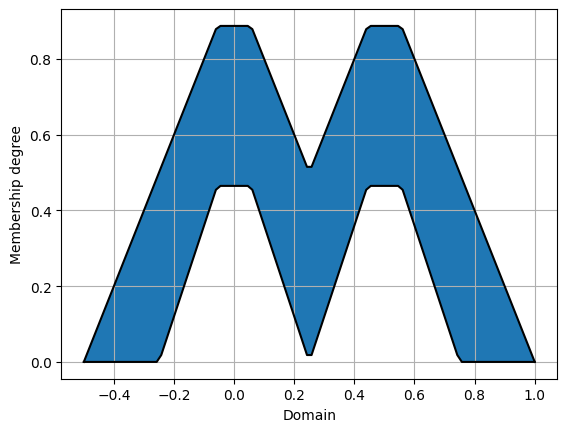

0.4248135588002589


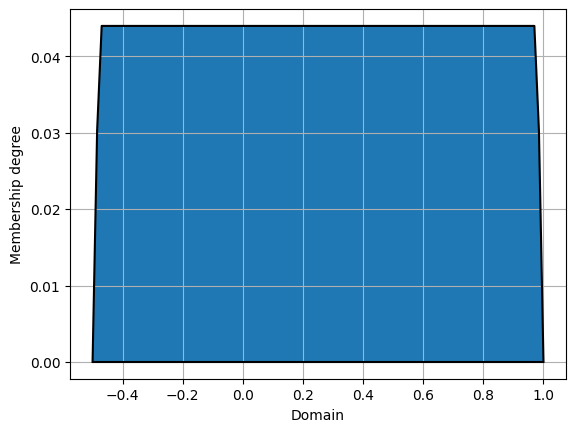

0.9848484848484849


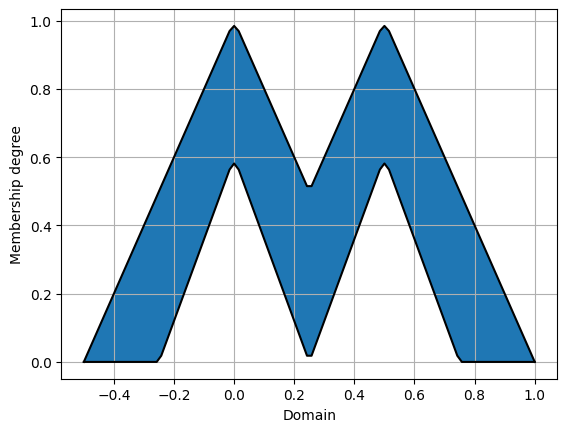

0.41951616797391333


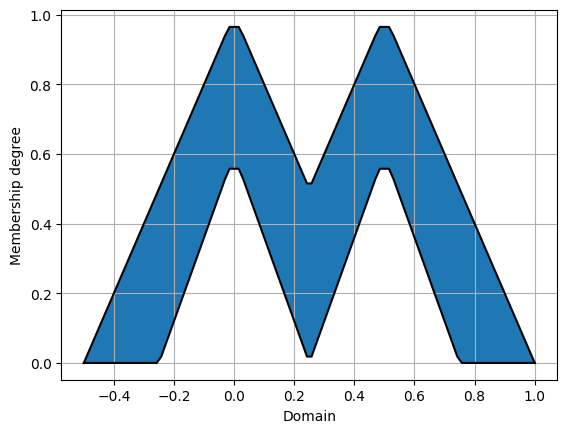

0.4199030568904269


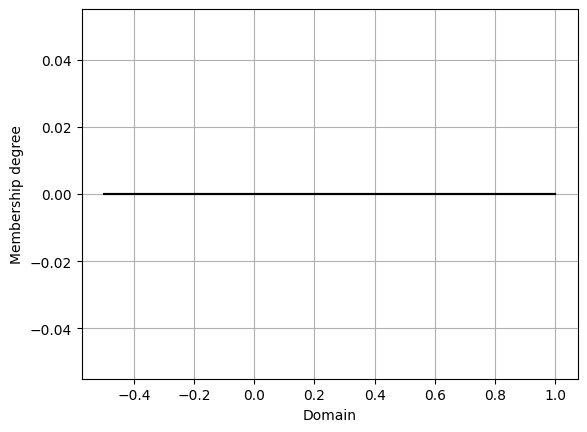

0.0


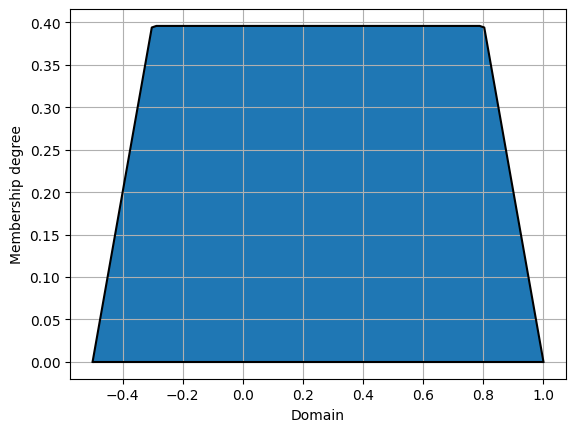

0.9848484848484849


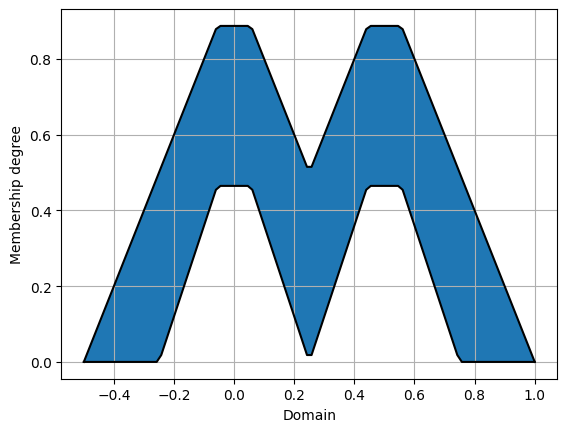

0.4248135588002589


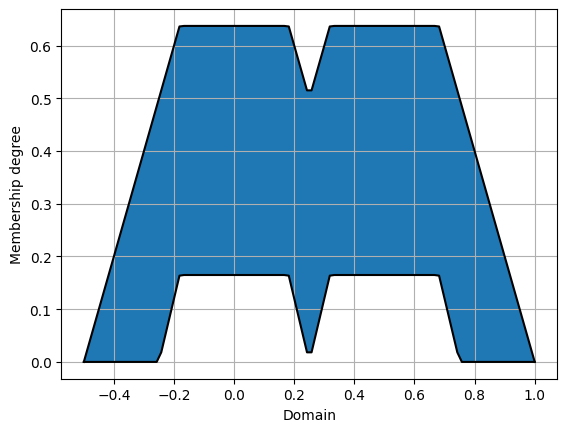

0.5005044082873213


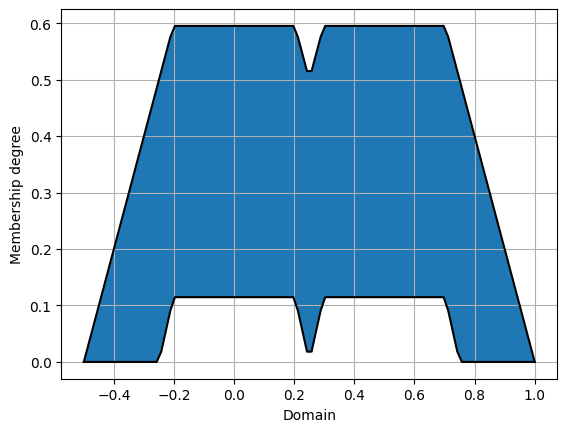

0.5359706669079479


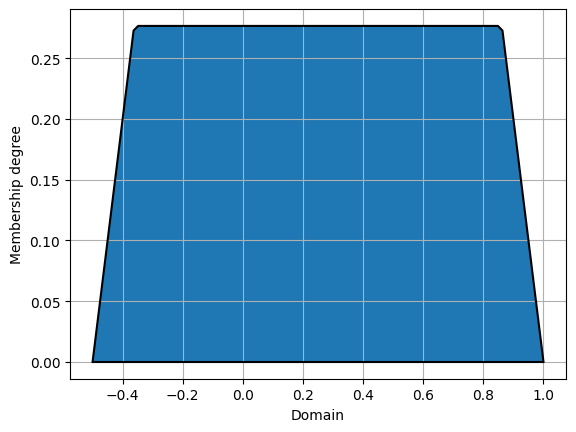

0.9848484848484849


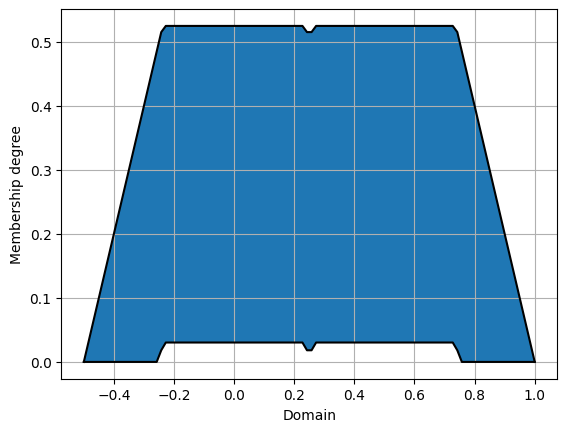

0.6651187726518699


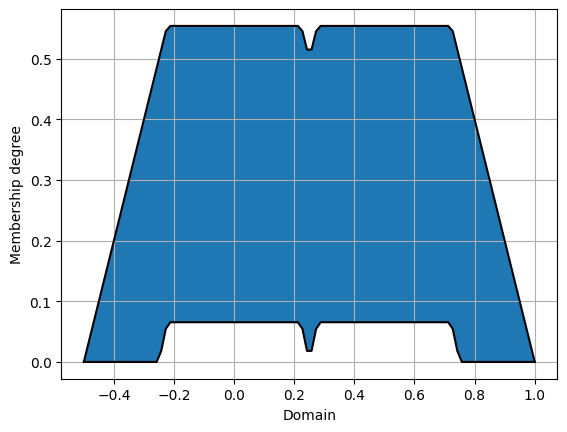

0.5920013046689226


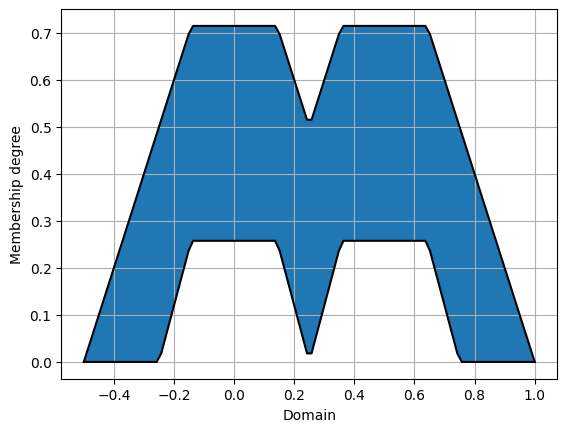

0.46156745990259196


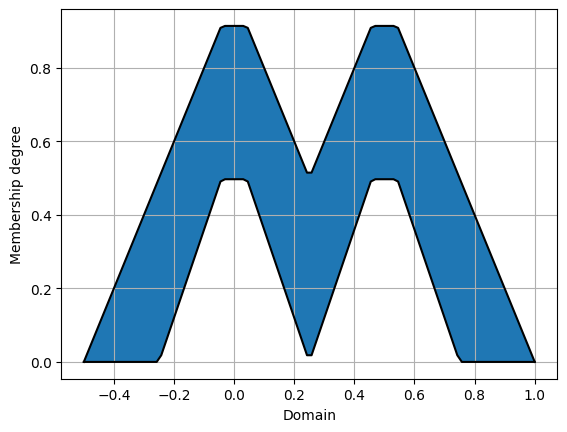

0.4224697637701517


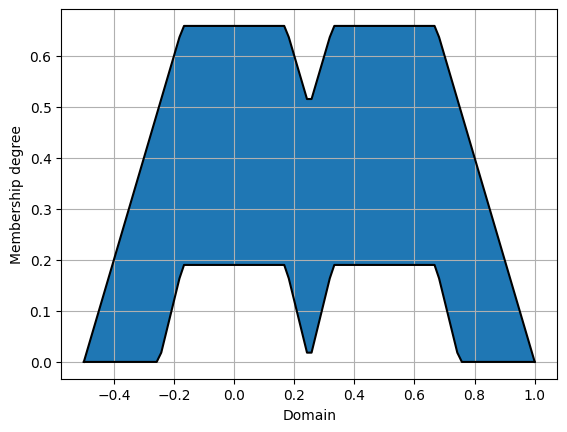

0.48755073380390734


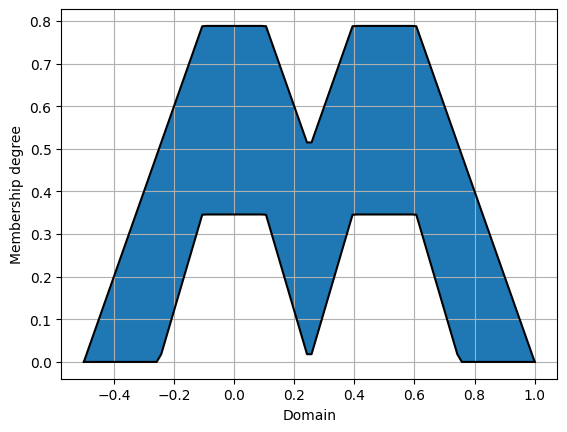

0.44012073442982524


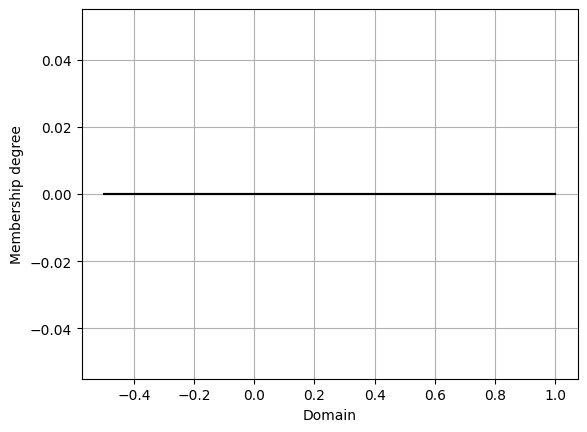

0.0


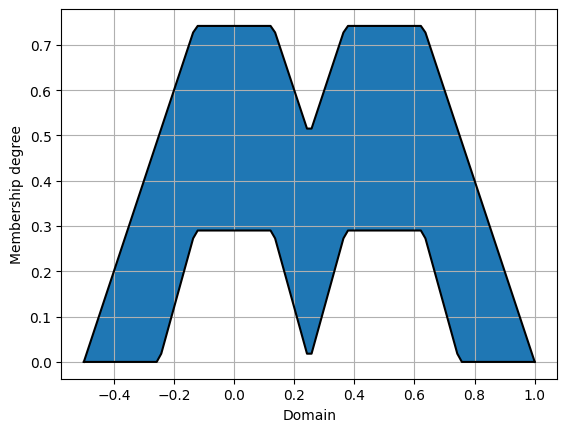

0.45241618799819155


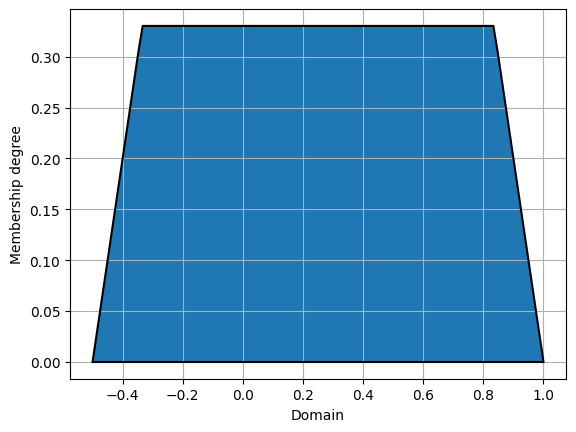

0.9848484848484849


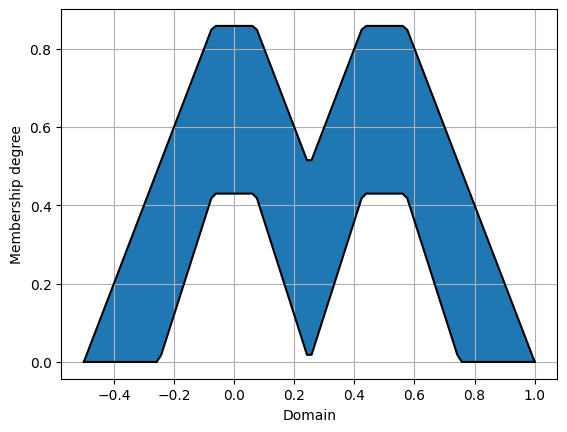

0.42817262079632507


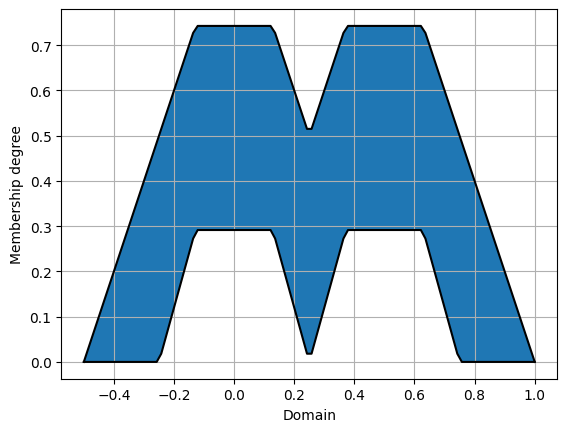

0.45203929899679696


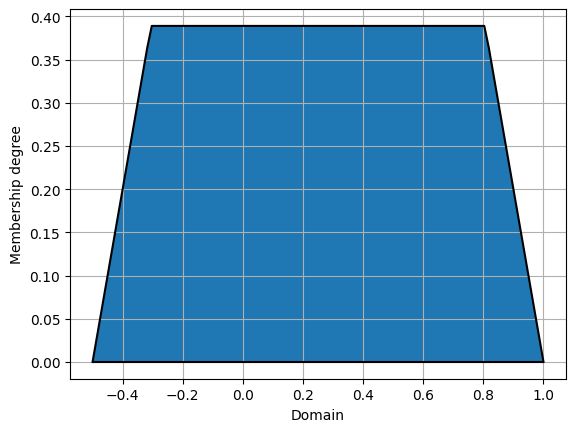

0.9848484848484849


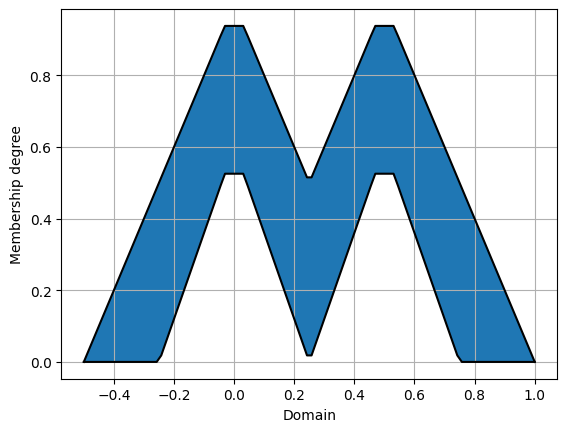

0.4209618072735829


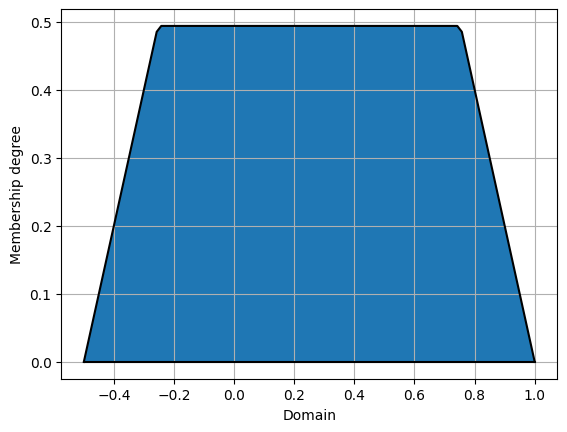

0.9848484848484849


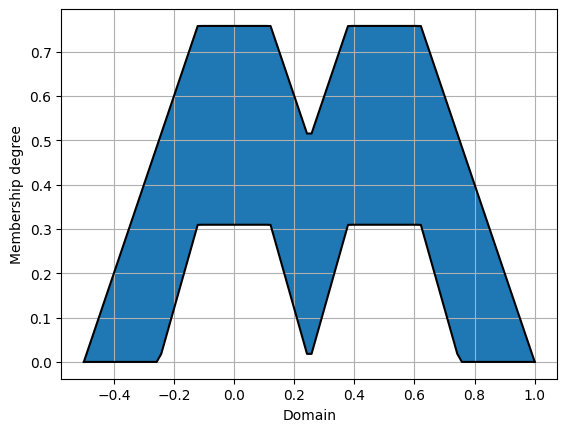

0.44764406520879485


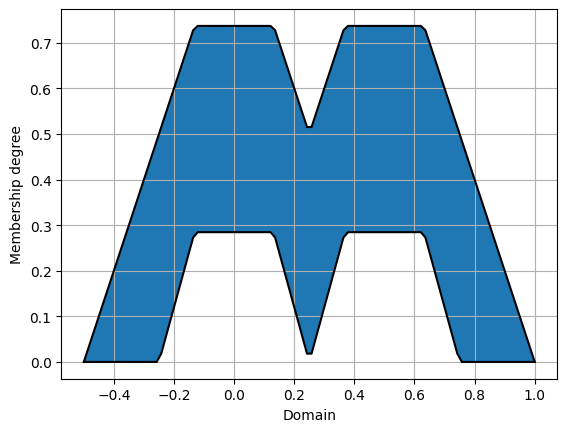

0.4538269227624018


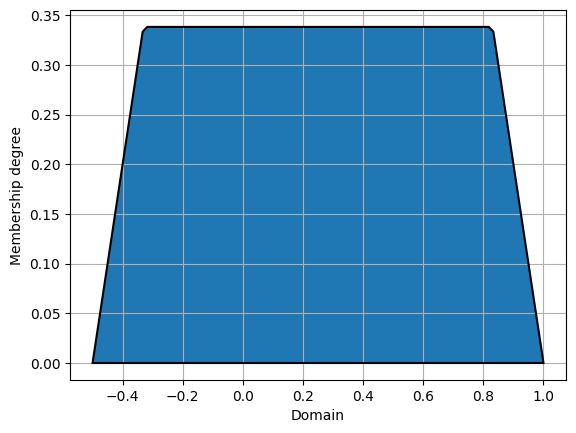

0.9848484848484849


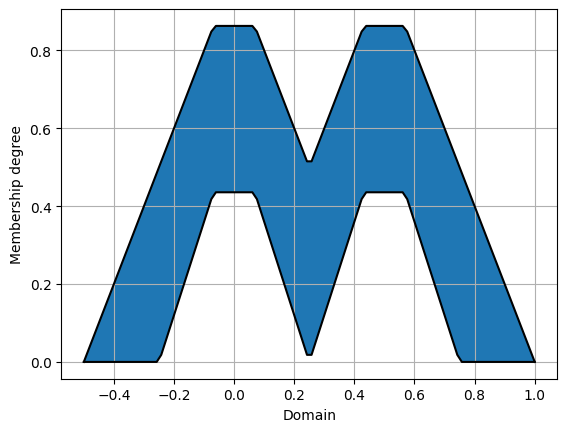

0.427562948581528


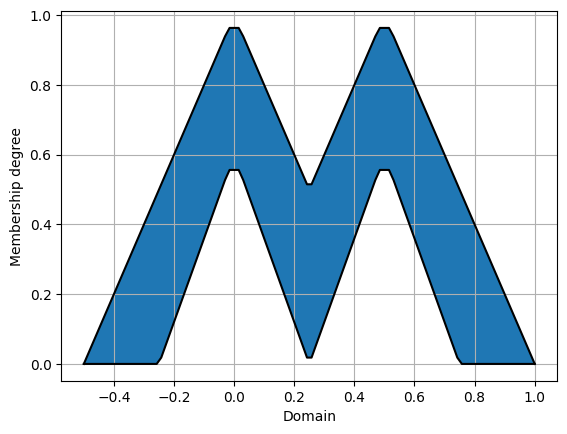

0.41993343253747173


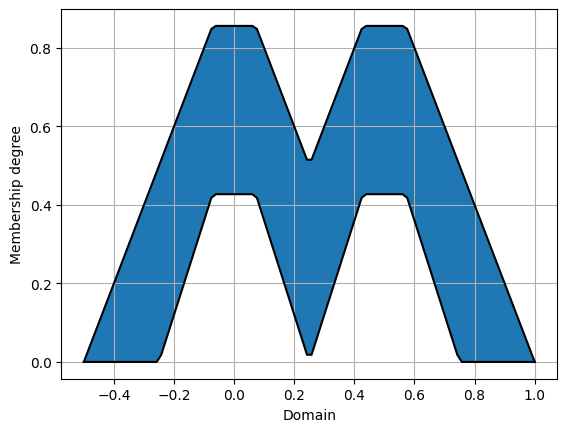

0.42843340006832975


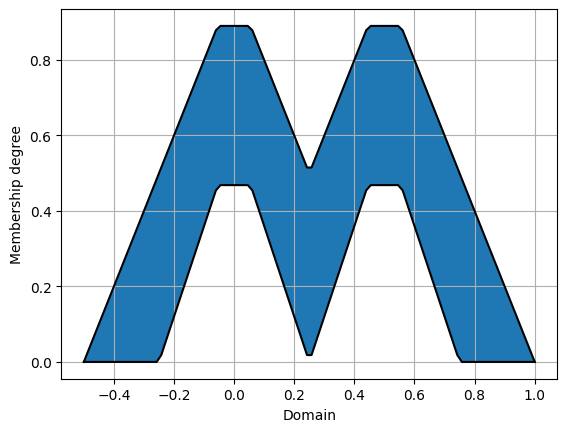

0.42452795760035283


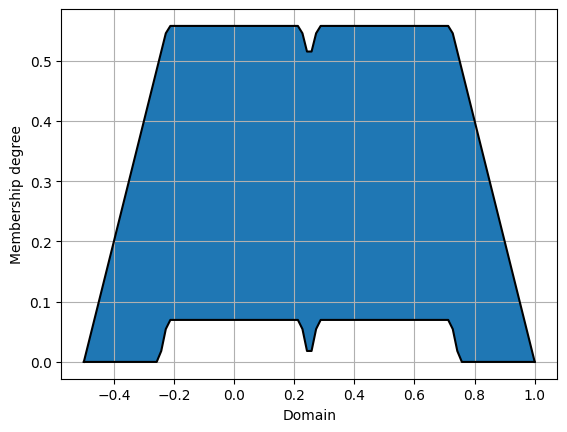

0.5858315769656861


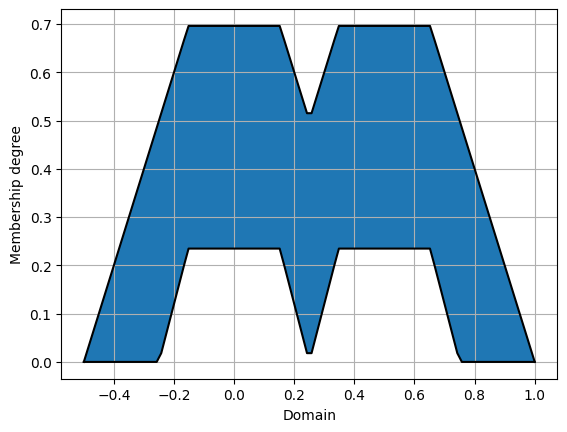

0.46902208417251967


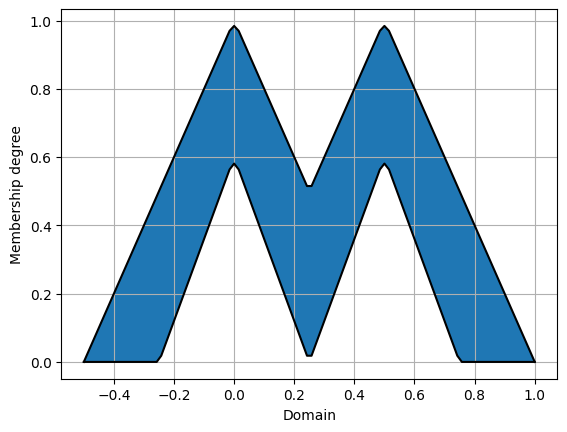

0.41952223603928296


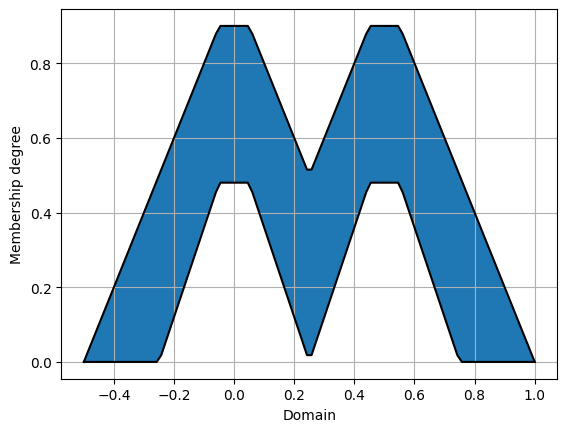

0.42362787654078915


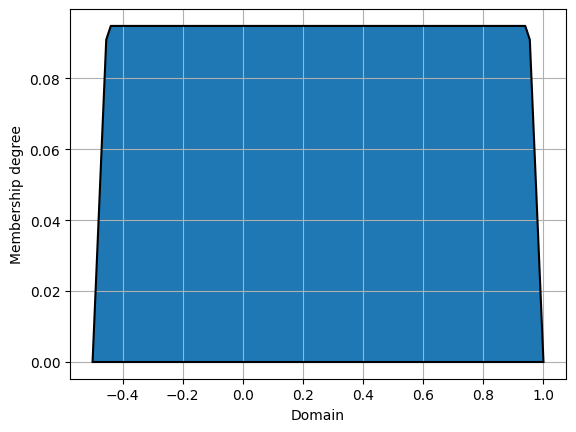

0.9848484848484849


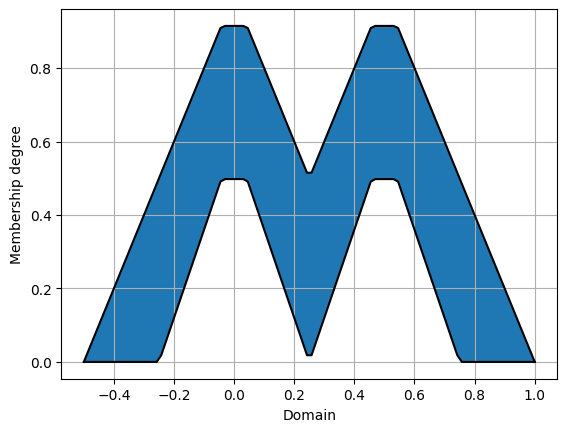

0.4224361608826627


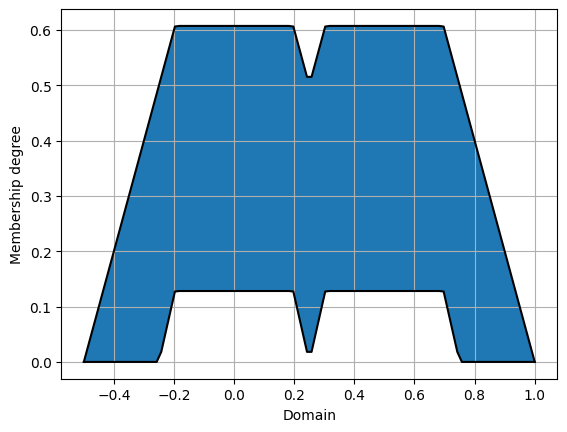

0.5248039543803524


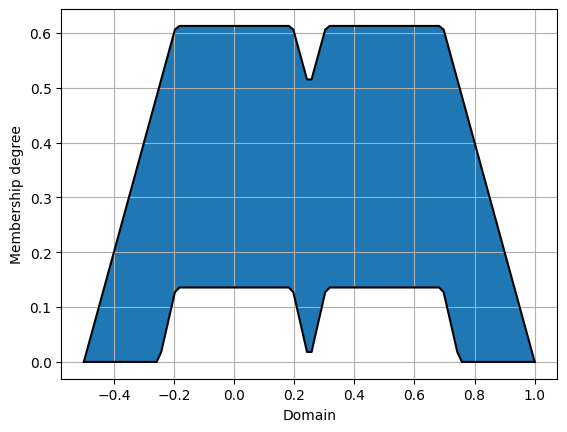

0.5192801016932989


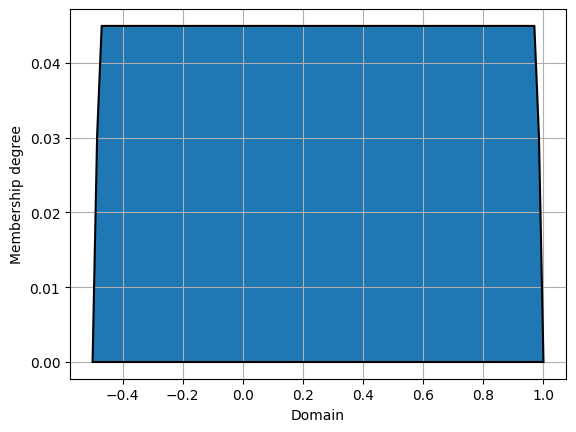

0.9848484848484849


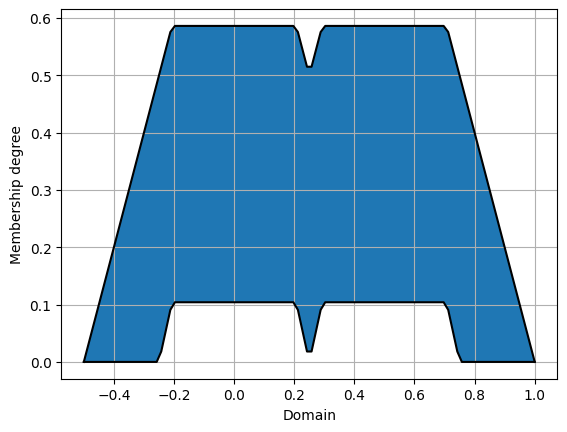

0.5455489012827346


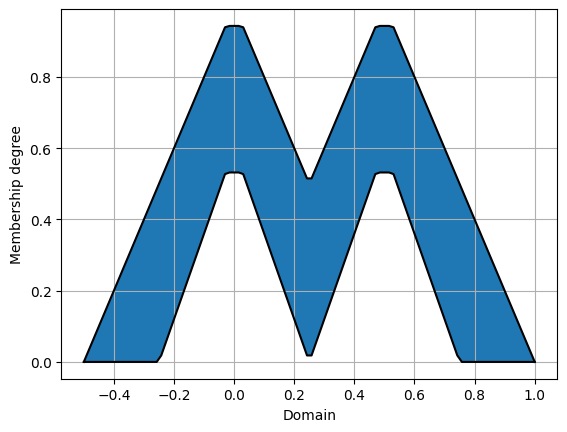

0.4207118315450014


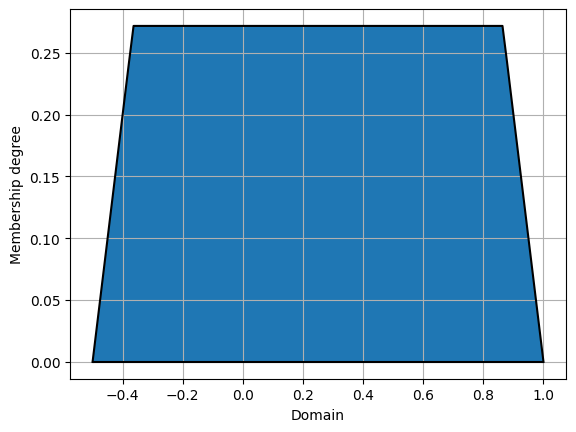

0.9848484848484849


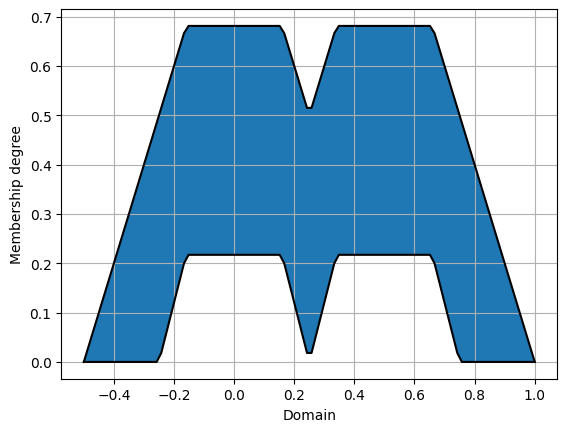

0.4758001328315844


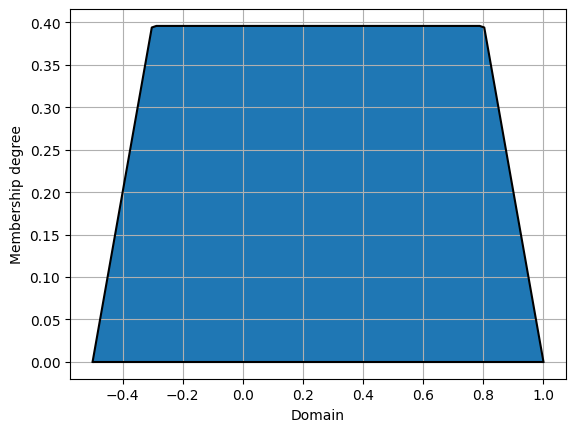

0.9848484848484849


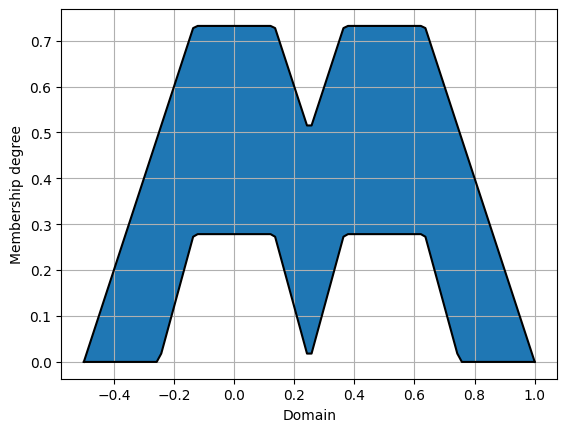

0.45543370632897046


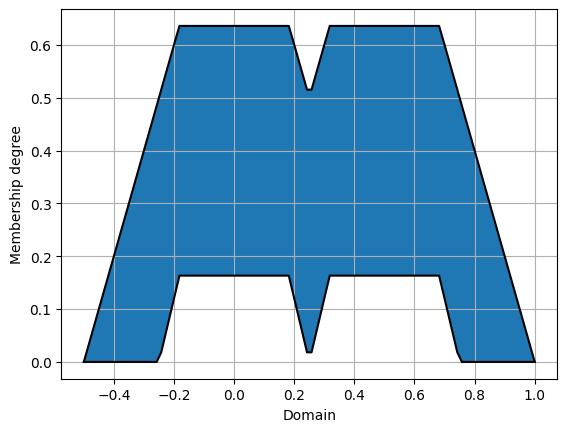

0.5014028774012


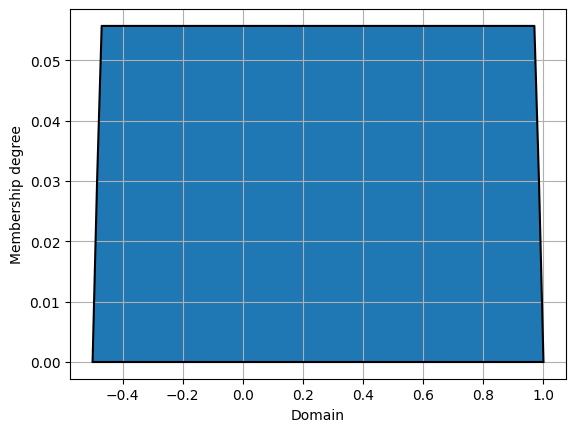

0.9848484848484849


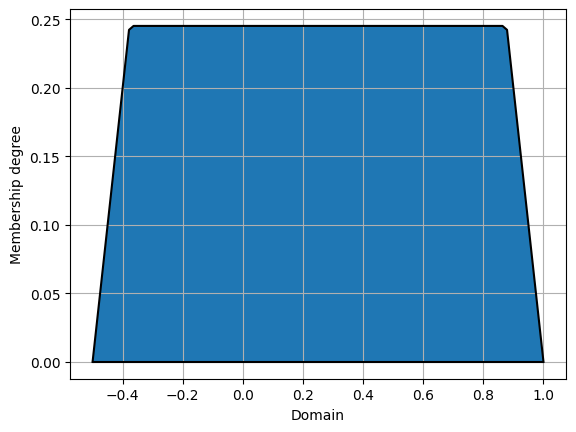

0.9848484848484849


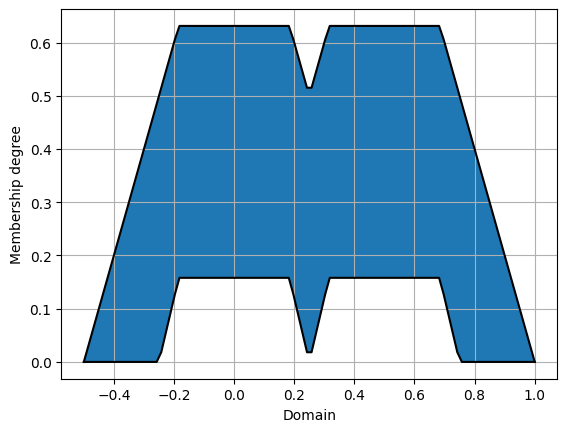

0.5046194430623409


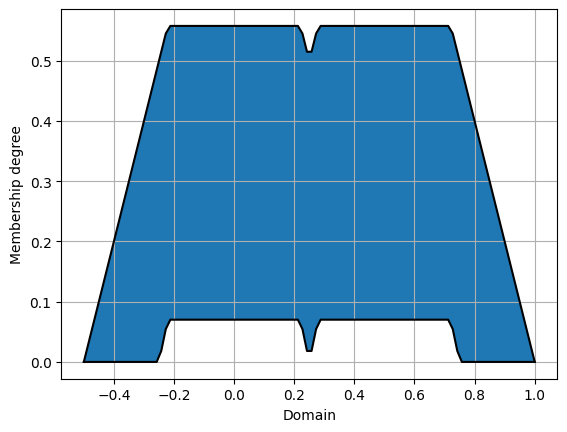

0.5852255378160302


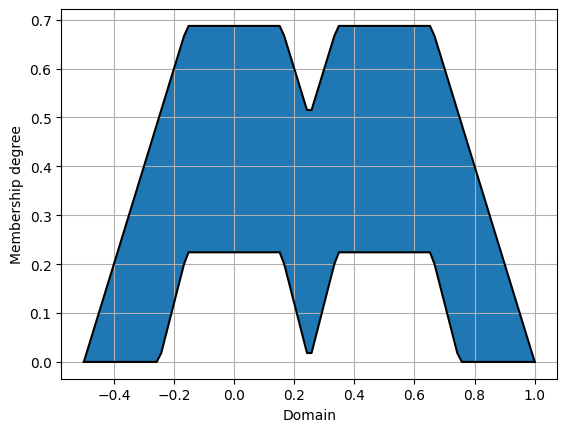

0.47303738471867635


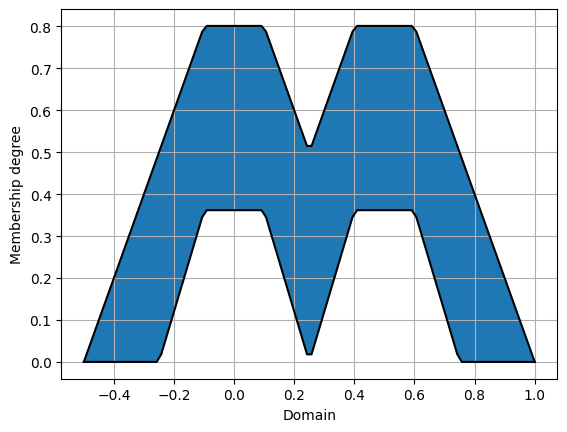

0.43745012037658537


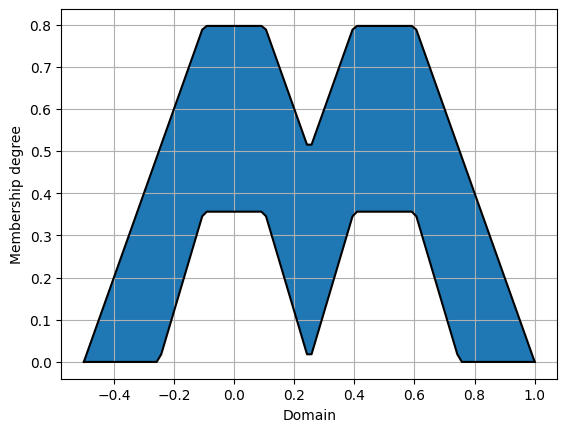

0.438392667463786


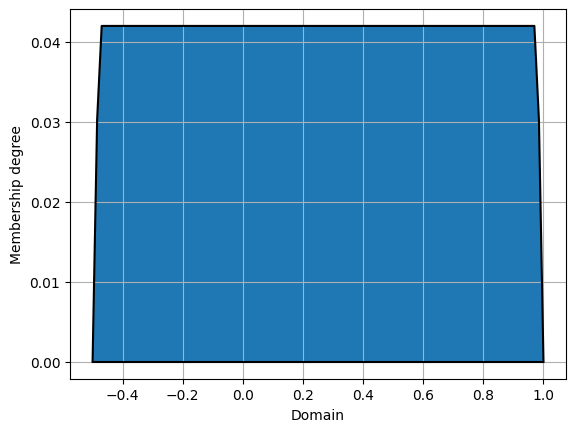

0.9848484848484849


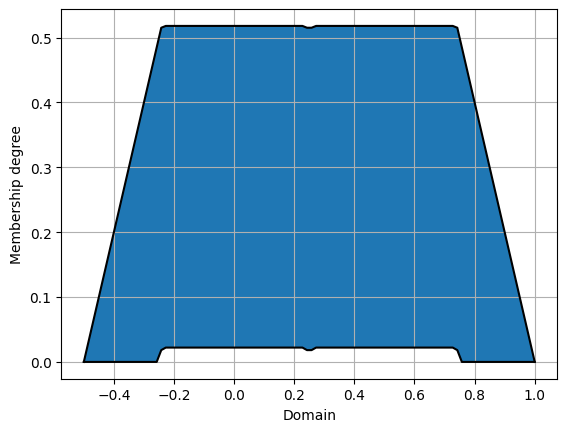

0.6919078699319081


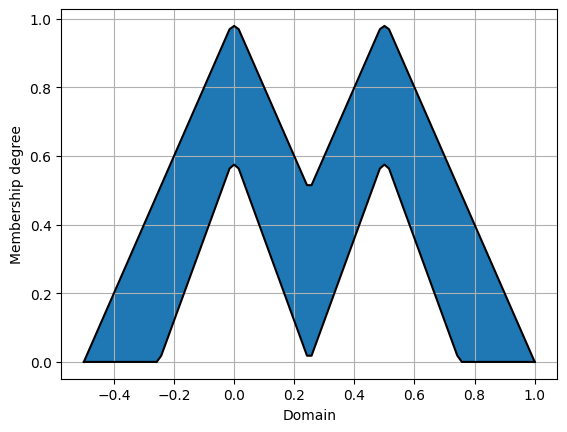

0.4195836570726165


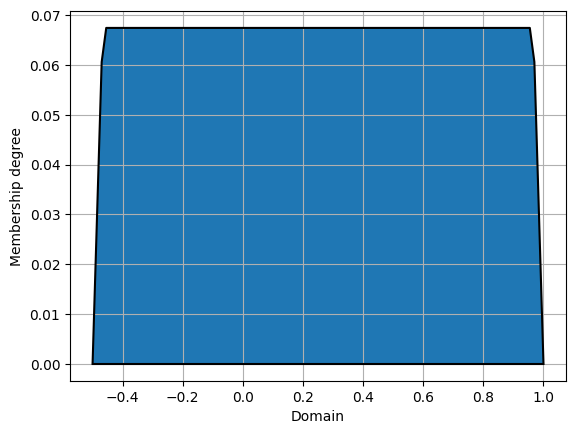

0.9848484848484849


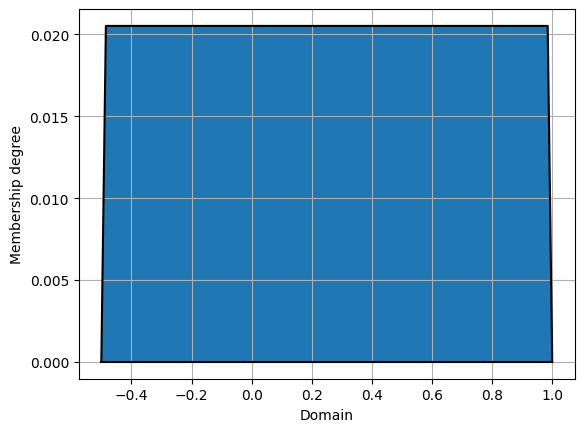

0.984848484848485


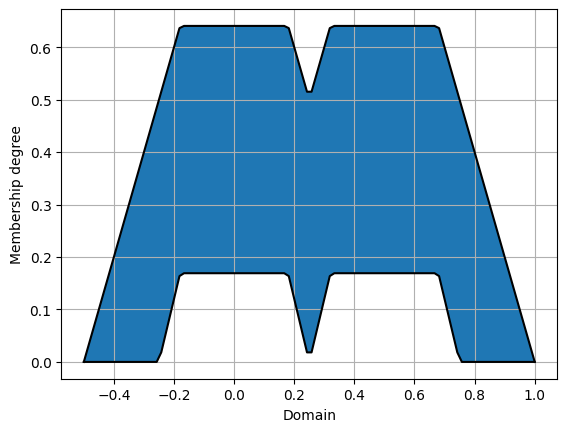

0.49821256666906166


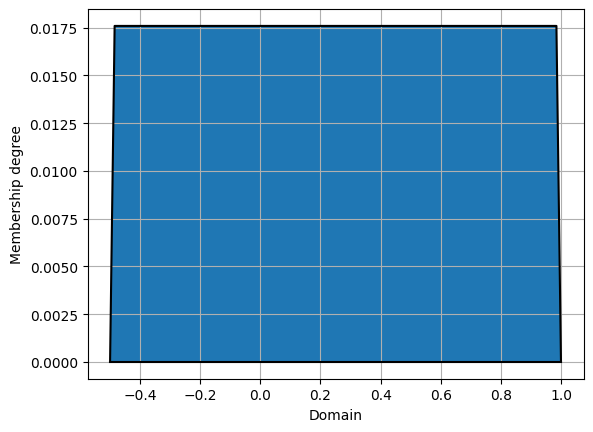

0.9848484848484849


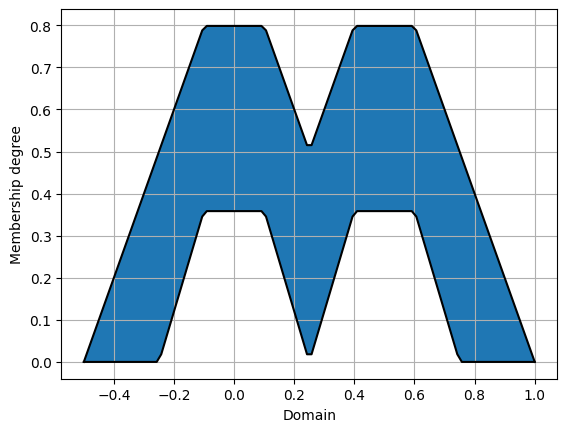

0.4380328870755401


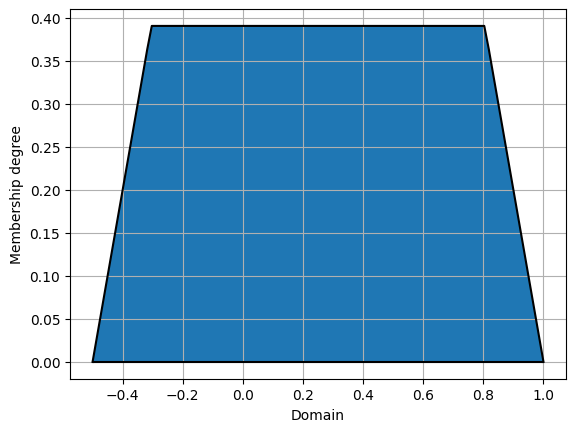

0.9848484848484849


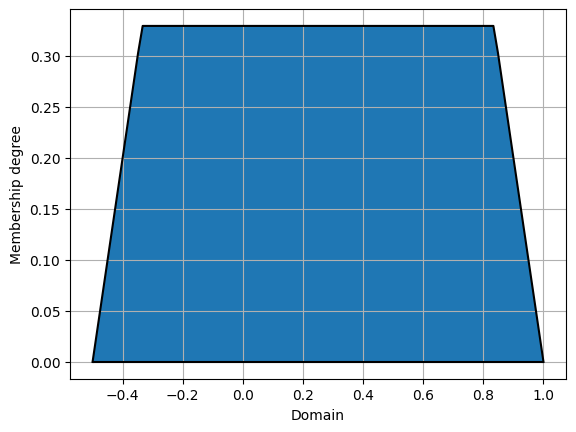

0.9848484848484849


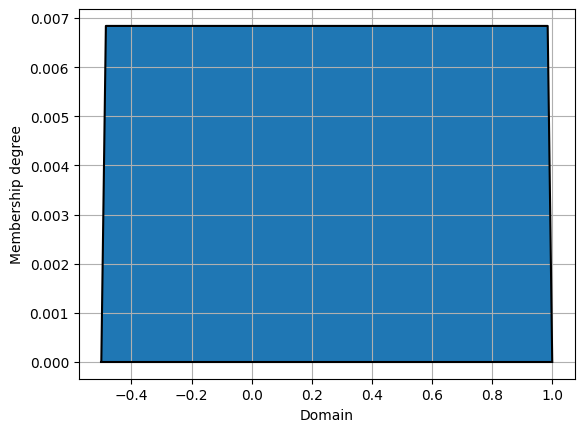

0.9848484848484849


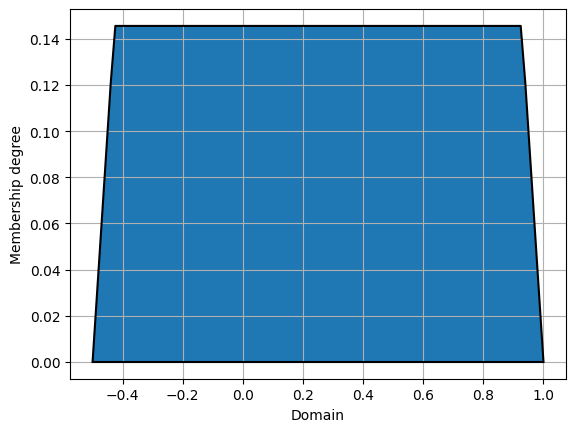

0.9848484848484849


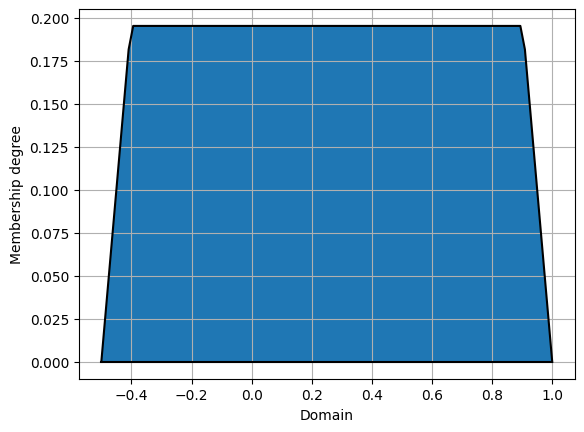

0.9848484848484849


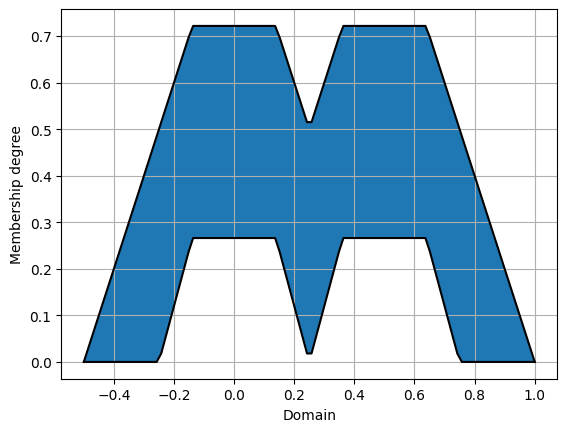

0.45894606263019644


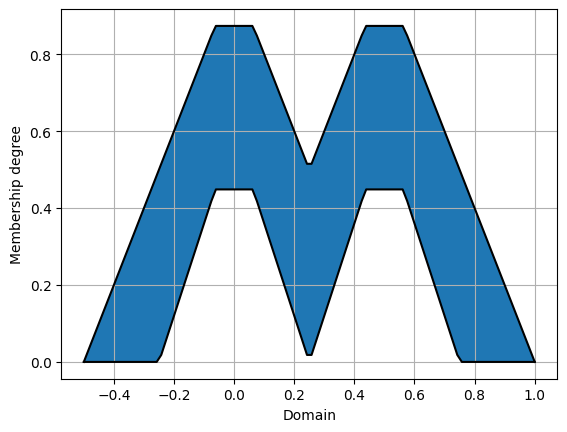

0.426234336385638


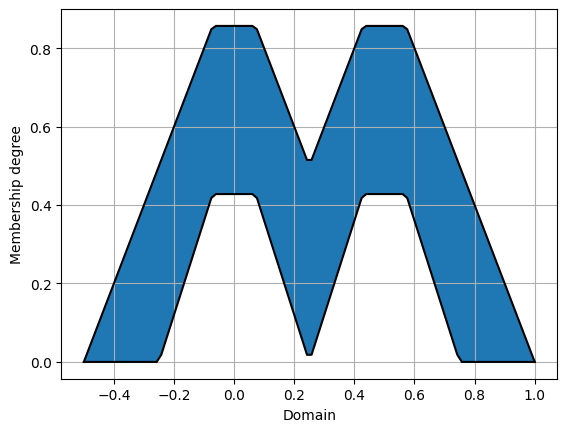

0.4283619339847619


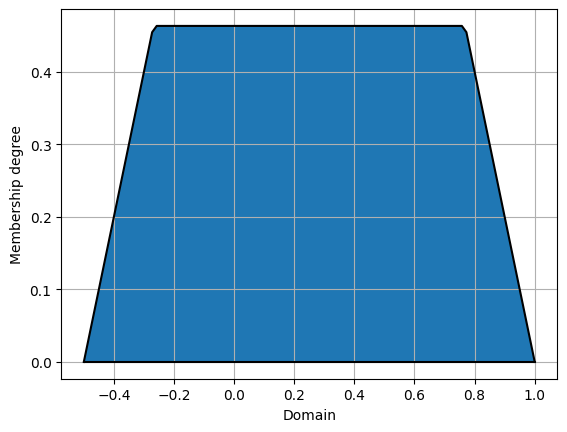

0.9848484848484849
31 40


In [48]:
# sample = train_dataset[100,:]
# feature_dict = {}
# for feature_index in range(9, 10):
#     # print(feature_names[feature_index], sample[feature_index])
#     feature_dict[feature_names[feature_index]] = sample[feature_index]
# domain = linspace(-0.5, 1, 100)
# print(feature_dict)
# it2out, tr = myIT2FLS.evaluate(feature_dict, product_t_norm, max_s_norm, domain, 
#                                method= "Centroid")
# print(it2out)
# print(tr)
# value = tr["Covid"][1]
# print(value)
# it2out["Covid"].plot()
# TR_plot(domain, tr["Covid"])
# print(crisp(tr["Covid"]))
true, false = 0, 0
for i in range (test_dataset.shape[0]):
    try:
        sample = test_dataset[i,:]
        feature_dict = {}
        for feature_index in range(9, 14):
            # print(feature_names[feature_index], sample[feature_index])
            feature_dict[feature_names[feature_index]] = sample[feature_index]
        # tipping.compute()
        it2out, tr = myIT2FLS.evaluate(feature_dict, min_t_norm, max_s_norm, domain, 
                               method= "Centroid", algorithm= "KM")
        it2out["Covid"].plot()
        # TR_plot(domain, tr["Covid"])
        # print(crisp(tr["Covid"]))
        value = tr["Covid"][1]
        print(value)
        if value >= 0.5:
            if sample [-1] == 1:
                true += 1
            else: 
                false += 1
            # print(str(sample[-1]) + " : " + "1")
        else:
            if sample [-1] == 0:
                true += 1
            else: 
                false += 1

    except:
        print(i)
        
print(true, false)

In [29]:
false / (true+false)

0.5961538461538461